# European options
A European call/put option is a contract between two parties, a buyer and a seller, giving the buyer the right but not obligation to buy/sell some underlying asset $S$ from/to the seller at a predetermined price $K$ (strike price) at a given time in the future $t$.

If $s_t$ is the value of the stock at time $t$, then the value of the call option at time $t$ is 
$$
C_t = \max(s_t - K, 0).
$$
Hence, the fair market value of the option at time 0 is 
$$
C_0 = e^{-rt} \mathbb{E}[\max(S_t - K, 0)],
$$
where $S_t$ is the distribution of the stock value at time $t$, and $r$ is the interest rate.

>**Note.** By call-put parity, under the risk-free assumption one has
>$$
>C_0 - P_0 = S_0 - e^{-rt}K.
>$$
>Hence, we will just focus on call options.


### Black-Scholes analytic formulas
By some relatively simple probability arguments, one can prove that the fair price of a European option is given by the following formulas.

Let $\varphi(x) = \frac{1}{\sqrt{2\pi}} e^{\frac{x^2}{2}}$ be the PDF of the normal distribution, and $\Phi(x) = \int_{-\infty}^x \varphi(t) dt$ be its CDF.

>**Theorem.** (**call/put formulas**) Let $S_t$ be GBM-distributed, $K$ be the strike price of a call/put option expiring at time $t$.  Denote by 
>$$
>d_1 = \frac{\ln\frac{S_0}{K} + (r + \frac{\sigma^2}{2})t}{\sigma \sqrt{t}}, \qquad
>d_2 = d_1 - \sigma\sqrt{t} = \frac{\ln\frac{S_0}{K} + (r - \frac{\sigma^2}{2})t}{\sigma \sqrt{t}}.
>$$
>Then
>$$
>C_0 = e^{-rt} \mathbb{E}[\max(S_t - K, 0)] = S_0 \Phi(d_1) - e^{-rt} K \Phi(d_2)
>$$
>and
>$$
>\mathbb{P}[S_t - K > 0] = \mathbb{P}[\text{call has value at time } t] = \Phi(d_2).
>$$
>Similarly,
>$$
>P_0 = e^{-rt} \mathbb{E}[\max(K - S_t, 0)] = -S_0 \Phi(-d_1) + e^{-rt} K \Phi(-d_2),
>$$
>and
>$$
>\mathbb{P}[K - S_t > 0] = \mathbb{P}[\text{put has value at time } t] = \Phi(-d_2).
>$$

##### Implementation
We implement the Black-Scholes pricer by the following code.  Again, the same code is available in `utils.py` and will be sourced from there for cross-notebook consistency.

```python
def bs_price(S0, K, sigma, t, r, option_type='call'):
    '''
    Black-Scholes Call Option formula

    Inputs:
    S0 (float): Stock price at time 0
    K (float): Strike Price
    sigma: Yearly volatility
    t: Time to expiration (years)
    r: Risk-free Interest rate


    Return:
    Black-Scholes value of call/put option (float)
    '''

    d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    
    if option_type == 'put':
        return -S0*norm.cdf(-d1) + K*np.exp(-r*t)*norm.cdf(-d2)
    elif option_type == 'call':
        return S0*norm.cdf(d1) - K*np.exp(-r*t)*norm.cdf(d2)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))
```

### Monte-Carlo pricing
European options under the GBM assumption have a nice closed-form formula for pricing, as explained in the previous section.  The fair price of the majority of financial instruments, however, cannot be determined analytically.  In such cases, a very powerful solution is to simulate different stock paths and use them to determine statistically the fair price of the derivative.  To illustrate the process, we first implement it for European options.  A naive implementation is as follows:
- we simulate `n_sims` GBM paths (with one step, since the only thing that matters for the moment is the final price);
- we take the terminal prices;
- depending on the type of option, we compute the payoff as $\max(S_t - K, 0)$ (call) or $\max(K - S_t, 0)$ (put);
- we compute the discounted payoffs at time 0;
- we return mean and standard deviation of the discounted payoffs.

In [1]:
from utils import GBM_paths

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")


def monte_carlo_european(S0, K, sigma, t, r, mu, n_sims, option_type="call"):
    """
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    n_sims (int): Number of simulated paths

    Returns:
    Estimated option price (float), standard deviation (float)
    """
    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps=1)
    S_t = paths[:, -1]  # Terminal prices

    if option_type == "call":
        payoffs = np.maximum(S_t - K, 0)
    elif option_type == "put":
        payoffs = np.maximum(K - S_t, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    discounted_payoff = np.exp(-r * t) * payoffs

    return np.mean(discounted_payoff), np.std(discounted_payoff) / np.sqrt(n_sims)

We can then compare the Monte-Carlo simulation of a European call option with the Black-Scholes solution, depending on the number of simulations.  We use the following starting data:
- starting price $S_0 = 100$
- interest rate $r = 4.25%$
- time horizon $t = 1$ year
- strike price $K = S_0$
- volatility $\sigma = 0.43$
- no drift ($\mu = 0$)

In [2]:
from utils import bs_price

simulations = [10, 100, 1_000, 10_000, 100_000, 1_000_000, 10_000_000]

S0 = 100
r = 0.0425
t = 1
K = S0
sigma = 0.43
mu = 0

analytic_price = bs_price(S0, K, sigma, t, r)
print(f"Black-Scholes computed value: ${analytic_price:.2f}")

for n_sims in simulations:
    call_value, std_err = monte_carlo_european(S0, K, sigma, t, r, mu, n_sims)
    print(
        f"Estimated call value with {n_sims} simulations: ${call_value:.2f} with standard error \
{std_err:.5f}"
    )

Black-Scholes computed value: $18.83
Estimated call value with 10 simulations: $33.49 with standard error 25.98357
Estimated call value with 100 simulations: $22.46 with standard error 3.85256
Estimated call value with 1000 simulations: $19.30 with standard error 1.14354
Estimated call value with 10000 simulations: $18.81 with standard error 0.33700
Estimated call value with 100000 simulations: $18.97 with standard error 0.10826
Estimated call value with 1000000 simulations: $18.77 with standard error 0.03379
Estimated call value with 10000000 simulations: $18.82 with standard error 0.01072


As one can see, the fair price estimated by Monte-Carlo methods converges to the Black-Scholes price as the number of simulations increases, and starts to be rather accurate already with about 100,000 simulations.

### Hedged Monte-Carlo pricing
Taking the market-maker's point of view, we can examine the profit distribution of selling 1 call option.  We assume a premium given by the Black-Scholes formula with slightly higher variance.

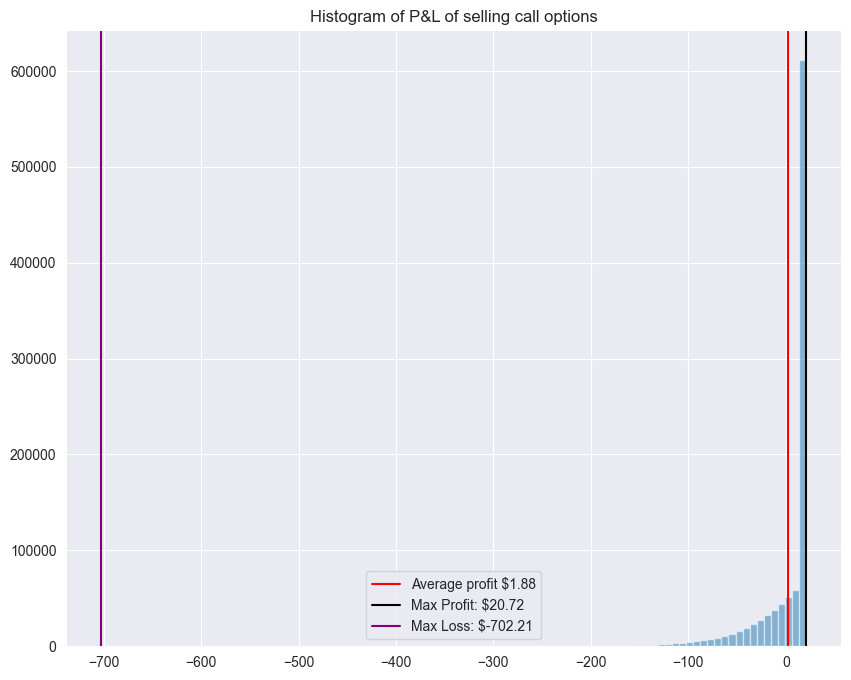

Black-Scholes expected profit: $1.89


In [3]:
S0 = 100
r = 0.0425
t = 1
K = S0
sigma = 0.43
mu = 0

premium = bs_price(S0, K, sigma + 0.05, t, r)

stock_paths = GBM_paths(S0, sigma, t, r, mu, n_sims=1_000_000, n_steps=1)
call_values_discounted = np.exp(-r * t) * np.maximum(stock_paths[:, -1] - K, 0)
profits = premium - call_values_discounted

profit_estimate = np.mean(profits)
profit_max = np.max(profits)
profit_min = np.min(profits)

plt.figure(figsize=(10, 8))
plt.hist(profits, bins=100, alpha=0.5)
plt.title(f"Histogram of P&L of selling call options")
plt.axvline(
    profit_estimate, color="red", label=f"Average profit ${profit_estimate:.2f}"
)
plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")
plt.legend()
plt.show()

bs_profit = premium - bs_price(S0, K, sigma, t, r)
print(f"Black-Scholes expected profit: ${bs_profit:.2f}")

As one can see, even though the Black-Scholes formula correctly estimates the average profit, one can nonetheless incur in huge losses.  To prevent this, the portfolio is hedged by buying and selling the underlying asset.

In this notebook, we will do delta-hedging.  To keep things realistic, we will do a daily hedge and introduce transaction costs.

##### $\Delta$ and delta-hedging
Let $C_0$ be the fair price of a European call option, as given by Black-Scholes. We define $\Delta_{C_0}$ as the derivative of $C_0$ with respect to the price $S_0$ of the underlying asset: $\Delta_{C_0} = \frac{\partial C_0}{\partial S_0}$.  One computes that $\Delta_{C_0} = \Phi(d_1)$.

Consider then a portfolio that buys $\Delta_{C_0}$ shares of stocks and sells one call option, so that the portfolio at time 0 (without including the premium) has value, according to Black-Scholes, $\Delta_{C_0} S_0 - C_0$.  Then the portfolio delta is $\Delta_{C_0} - \Delta_{C_0} = 0$, and the overall value of the portfolio remains unchanged by instantaneous variations of the value of the stock ("delta-neutral").

In simulations, we split $[0, t]$ into regular intervals, with $t_n = t$, $t_0 = 0$.  Let $C_{t_i}$ be the B-S price of the option at time $t_i$, and $\Delta_{C_{t_i}} = \frac{\partial C_{t_i}}{\partial S_{t_i}}$.  We readjust the portfolio to delta-neutral at each time $t_i$, i.e. to have $\Delta_{C_{t_i}}$ shares of stock.

The expected profit at time 0 of one share of stock from time $t_i$ to time $t_{i+1}$ is
$$
\left(S_{t_{i+1}} - e^{r(t_{i+1} - t_i)} S_{t_i} \right) e^{-r t_{i+1}}
$$
(the exponent outside of the parentheses is the discount to time 0, the one inside is the forward price from time $t_i$ to time $t_{i+1}$).  Thus the total stock profits by holding $\Delta_{C_{t_i}}$ shares at each interval of time is
$$
\sum_{i=0}^{n-1} \left(S_{t_{i+1}} - e^{r(t_{i+1} - t_i)} S_{t_i} \right) e^{-r t_{i+1}} \Delta_{C_{t_i}}.
$$
If $N$ options are sold for a premium $P$ each, then the profit/loss of the hedged portfolio is
$$
N(P - \max(S_t - K, 0) e^{-rt} + \text{stock profit}).
$$
The expected profit under the risk-free GBM assumption is then
$$
P - C_0 + 0,
$$
because each stock profit is expected to be 0 on each interval under the risk-free assumption, so the expected profit isn't influenced by delta-hedging.  However, it affects profit distribution, making extreme losses less likely.

In fact, continuous delta-hedging also removes the effect of any drift term $\mu$, making the option's actual value to be close to the B-S fair price.  Increasing the frequency of hedging makes the value closer to B-S.  This means that the profit from a hedging portfolio will be close to the option B-S value, avoiding big payouts.

We implement a Monte-Carlo simulation of a European call option with delta-hedging as follows.  Again, the code is available in `utils.py`, and it will be sourced from there for cross-notebook consistency.

```python
def monte_carlo_european(S0, K, sigma, t, r, mu, n_sims, n_hedges, return_distribution=True, option_type='call'):
    """Monte-Carlo simulation of a European option value with Black-Scholes assumptions with delta hedging.

    Inputs:
    S0 (float): underlying stock price at time 0
    K (float): strike price
    sigma (float): yearly volatility
    t (float): time to expiration (years)
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_sims (int): number of simulated paths
    n_hedges (int): number of delta-hedges
    
    Returns:
    If return_distribution is true, returns distribution of simulated call values with delta hedging;
      if false, returns the average payoff and standard deviation of call option with delta hedging

    To simulate the profit distribution of selling n_options number of call options for a premimum, run
    n_options*(premium - monte_carlo_european(S0, K, sigma, t, r, mu, n_sims, n_hedges) - tr_cost*n_hedges)
    
    """
    if n_hedges == 0:
        paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps=1)
        S_t = paths[:, -1]  # Terminal prices

        if option_type == 'call':
            discounted_payoff = np.exp(-r * t) * np.maximum(S_t - K, 0)
        elif option_type == 'put':
            discounted_payoff = np.exp(-r * t) * np.maximum(K - S_t, 0)
        else:
            raise ValueError("Unrecognized option type: {}".format(option_type))

        if return_distribution:
            return discounted_payoff
        else:
            return np.mean(discounted_payoff), np.std(discounted_payoff)/np.sqrt(n_sims)

    else:
        paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_hedges)
        S_t = paths[:, -1]  # Terminal prices

        if option_type == 'call':
            discounted_payoff = np.exp(-r * t) * np.maximum(S_t - K, 0)
        elif option_type == 'put':
            discounted_payoff = np.exp(-r * t) * np.maximum(K - S_t, 0)
        else:
            raise ValueError("Unrecognized option type: {}".format(option_type))

        times = np.linspace(0, t, n_hedges + 1)

        deltas = bs_delta(stock_paths[:,0:n_hedges], K, sigma, (t-times)[0:n_hedges], r, option_type=option_type)

        stock_profits_discounted = (stock_paths[:,1:n_hedges + 1] - \
                                    stock_paths[:,0:n_hedges]*np.exp(r*dt))*np.exp(-r*times[1:n_hedges+1])*deltas

        profit_of_call_with_hedging = call_payout_discounted - np.sum(stock_profits_discounted, axis=1)

        if return_distribution:
            return profit_of_call_with_hedging
        else:
            return np.mean(profit_of_call_with_hedging), np.std(profit_of_call_with_hedging)/np.sqrt(n_sims)
```

Below we simulate the effect of the number of hedges on the profit of a market-maker selling a European call option.  We assume a transaction price of $0.0020 per transaction.

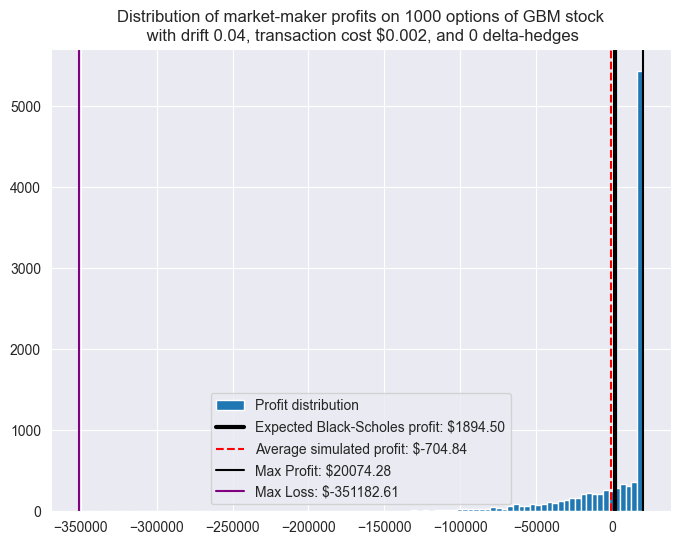

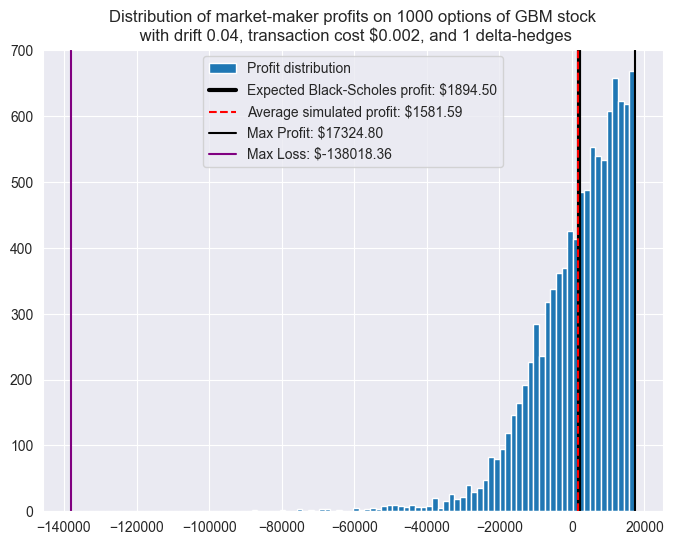

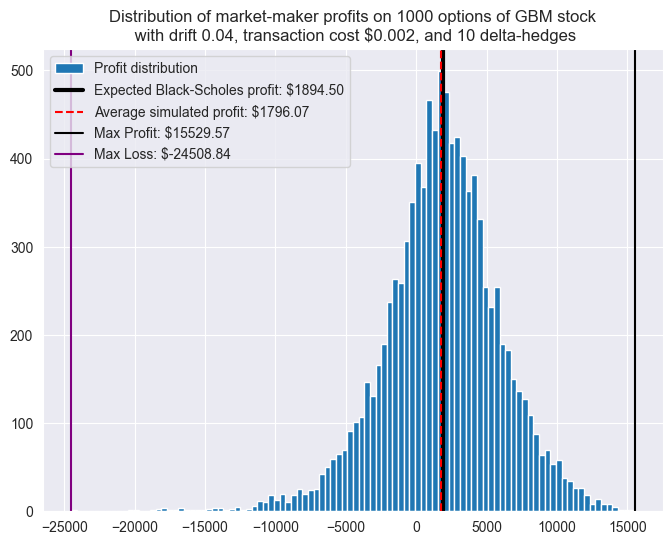

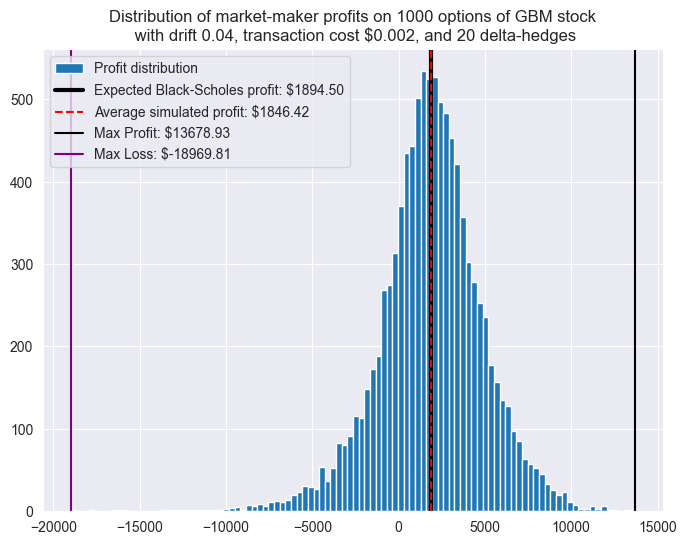

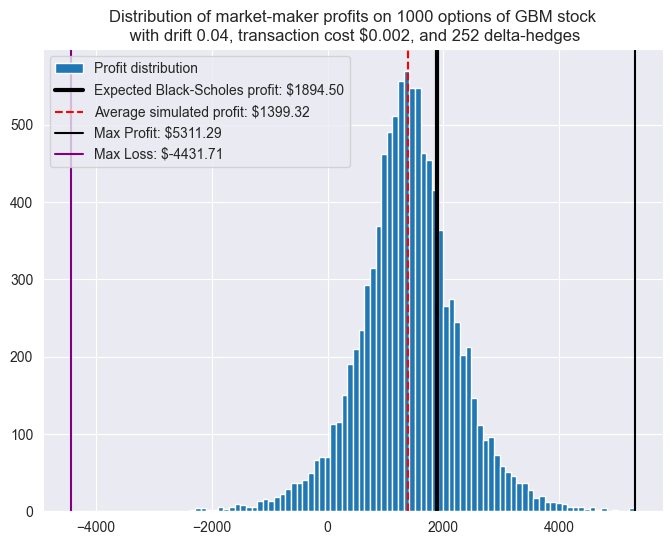

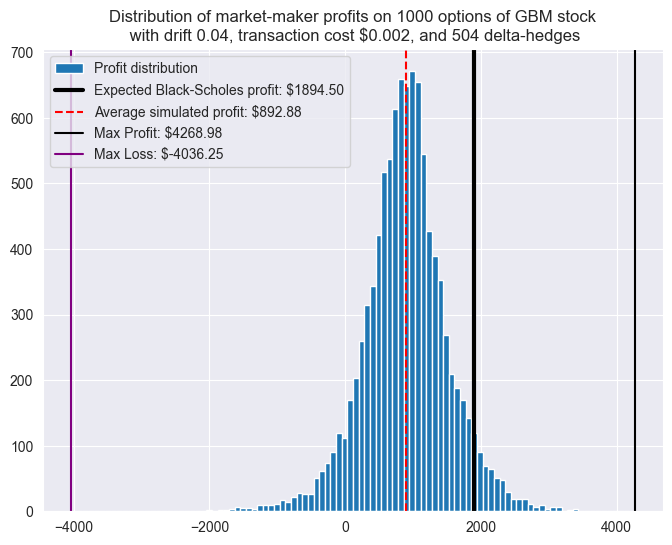

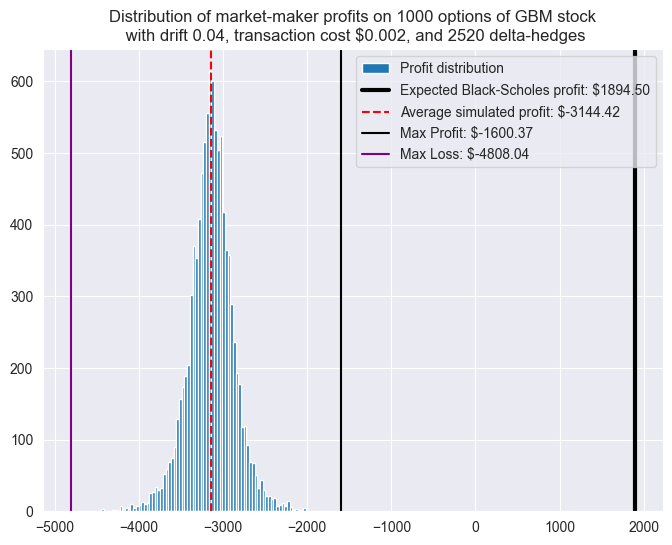

In [4]:
from utils import monte_carlo_european, bs_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = 0.04
n_sims = 10_000
tr_cost = 0.002
n_options = 1_000
premium = bs_price(S0, K, sigma + 0.05, t, r)

hedging_amounts = [0, 1, 10, 20, 252, 504, 2520]

for n_hedges in hedging_amounts:
    call_value_distribution = monte_carlo_european(
        S0,
        K,
        sigma,
        t,
        r,
        mu,
        n_sims,
        n_hedges,
        return_distribution=True,
        option_type="call",
    )

    profit_distribution = n_options * (
        premium - call_value_distribution - tr_cost * n_hedges
    )
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - bs_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected Black-Scholes profit: ${n_options*(premium - bs_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_hedges} delta-hedges"
    )
    plt.legend()
    plt.show()

As one can see, introducing delta-hedging makes the simulated profit closer to the expected one for infrequent hedging, eliminating the effect of drift and reducing the width of the spectrum of profits.  However, when the number of hedges becomes sufficiently big, transaction costs start to play a significant role.  For instance, 10 hedges per day would surely make hedging unprofitable.  A reasonable spot seems to be one or two hedges per day.

##### Self-financing portfolio
The delta-hedging strategy implemented above assumes that cash can freely flow in and out of the portfolio for each hedging step.  In real world, hedging portfolios instead are *self-financing*: at each step the portfolio holds $\Delta_i$ shares of stock and $B_i$ of cash/bonds.  Hence, the portfolio value is $V_i = \Delta_i S_i + B_i$.  The bond grows at the risk-free rate, and thus updates as $B_{i+1} = B_i e^{r dt}$, and there is no cash-flow entering or exiting the portfolio at intermediate times.

Here is an implementation of a self-financing hedging portfolio for European options (from `utils.py`).

```python
def mc_eur_sf_hedged(S0, K, sigma, t, r, mu, premium, n_sims, n_steps, option_type="call"):
    """Market-maker's profits on a self-financing European option delta-hedging portfolio
    S0 (float): Underlying stock price at time 0
    sigma (float): Yearly volatility
    t (float): Time to expiration (years)
    r (float): Risk-free interest rate
    mu (float): Drift of log-returns
    premium (float): Premium of selling one option
    n_sims (int): Number of simulated paths
    n_steps (int): Number of steps in the average

    Returns:
    Distribution of profits
    """
    dt = t / n_steps

    paths = GBM_paths(S0, sigma, t, r, mu, n_sims, n_steps)
    S = paths[:,-1]

    if option_type == "call":
        payoff = np.maximum(S - K, 0)
    elif option_type == "put":
        payoff = np.maximum(K - S, 0)
    else:
        raise ValueError("Unrecognized option type: {}".format(option_type))

    # initial delta and bond position
    Delta = bs_delta(S0, K, sigma, t, r, option_type=option_type)
    V = premium
    B = V - Delta * S0


    for i in range(n_steps):
        S_next = paths[:, i+1]

        # bond accrues interest
        B *= np.exp(r * dt)

        # portfolio value before rebalancing
        V = Delta * S_next + B

        # compute new delta
        tau = t - (i + 1) * dt
        new_Delta = (1 - (i + 1)/n_steps) * (S_eff / S_next) * bs_delta(
            S_next, K, sigma, tau, r, option_type=option_type
        )

        # adjust bond for rebalancing cost
        B = B - (new_Delta - Delta) * S_next

        # update delta
        Delta = new_Delta

    V = Delta * S_next + B
    
    return (V - payoff) * np.exp(-r*t)
```

We run the same simulation as before with the self-hedging portfolio.

/home/roberto/Desktop/Learning/Quant finance bootcamp/Project/utils.py:50: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0/K) + (r + (0.5)*sigma**2)*t)/(sigma*np.sqrt(t))


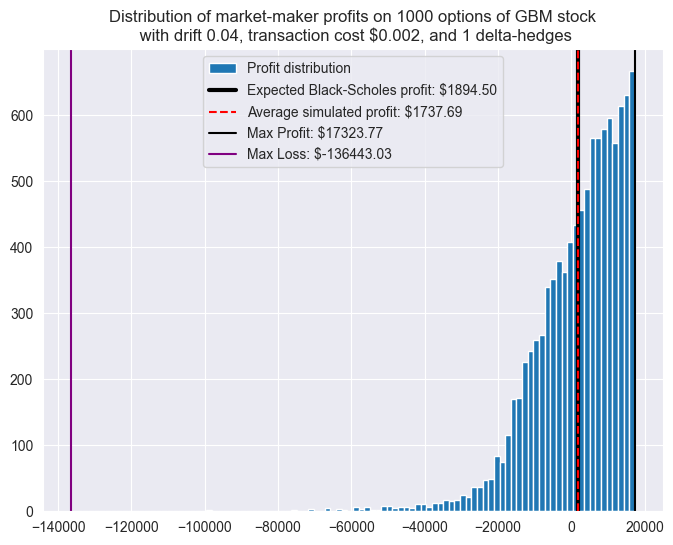

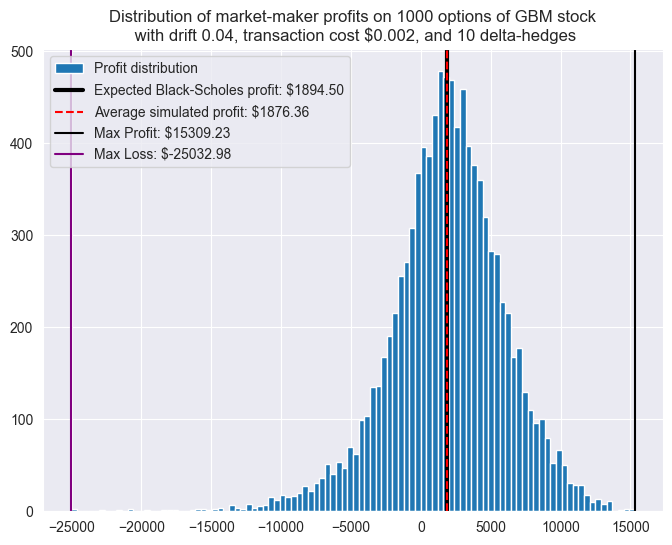

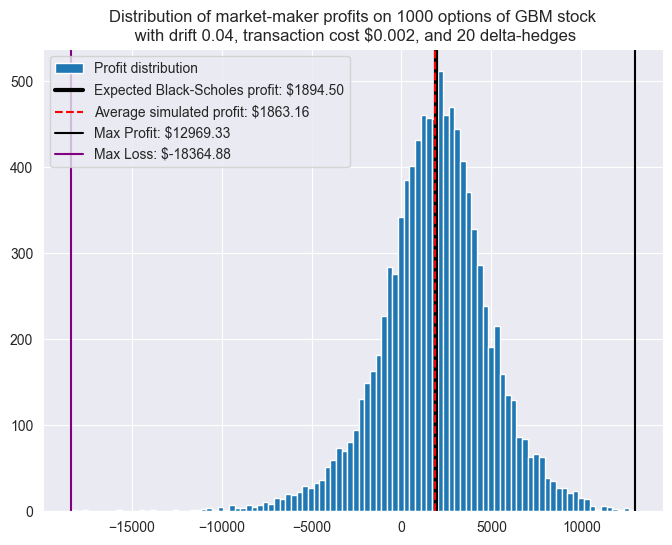

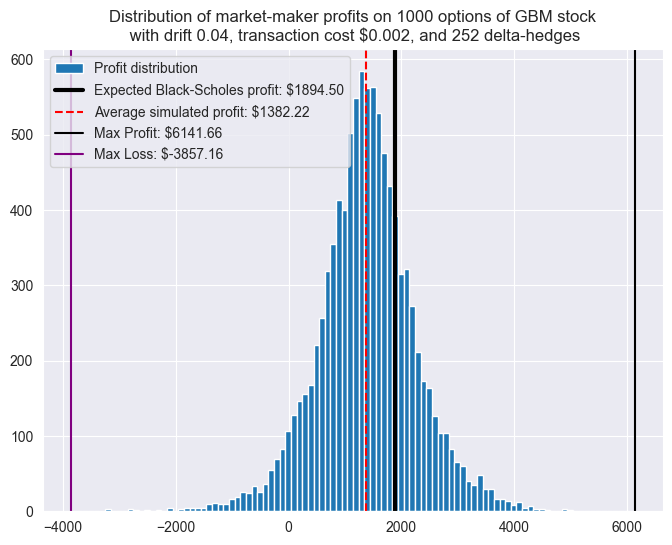

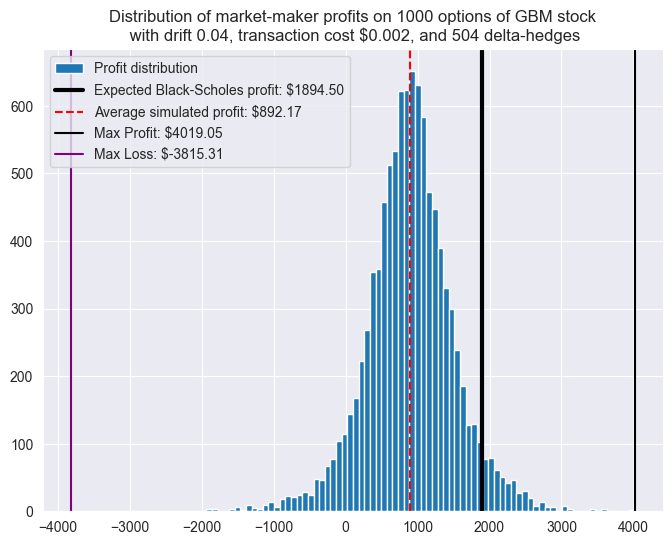

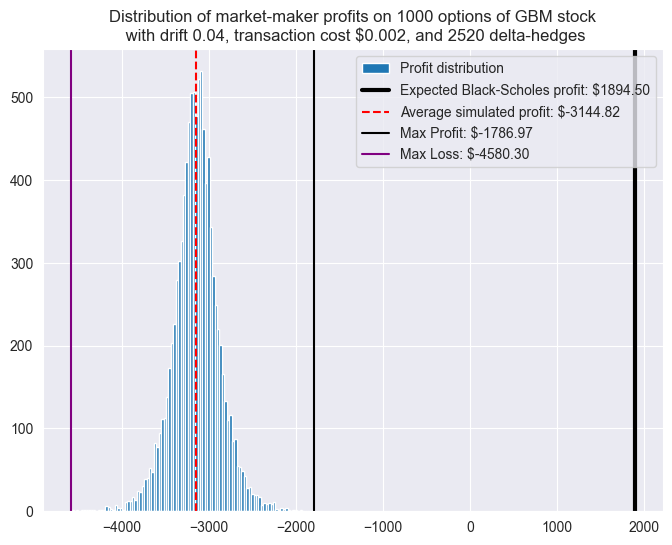

In [5]:
from utils import mc_eur_sf_hedged, bs_price

S0 = 100
K = 100
sigma = 0.41
t = 1
r = 0.045
mu = 0.04
n_sims = 10_000
tr_cost = 0.002
n_options = 1_000
premium = bs_price(S0, K, sigma + 0.05, t, r)

hedging_amounts = [1, 10, 20, 252, 504, 2520]

for n_hedges in hedging_amounts:
    unit_profits = mc_eur_sf_hedged(
        S0,
        K,
        sigma,
        t,
        r,
        mu,
        premium,
        n_sims,
        n_hedges,
        option_type="call",
    )

    profit_distribution = n_options * (unit_profits - tr_cost * n_hedges)
    average_profit = np.mean(profit_distribution)

    plt.figure(figsize=(8, 6))

    plt.hist(profit_distribution, bins=100, label="Profit distribution")

    plt.axvline(
        n_options * (premium - bs_price(S0, K, sigma, t, r)),
        color="black",
        lw=3,
        label=f"Expected Black-Scholes profit: ${n_options*(premium - bs_price(S0,K,sigma,t,r)):.2f}",
    )

    plt.axvline(
        average_profit,
        ls="--",
        color="red",
        label=f"Average simulated profit: ${average_profit:.2f}",
    )

    profit_max = np.max(profit_distribution)
    profit_min = np.min(profit_distribution)
    plt.axvline(profit_max, color="black", label=f"Max Profit: ${profit_max:.2f}")
    plt.axvline(profit_min, color="purple", label=f"Max Loss: ${profit_min:.2f}")

    plt.title(
        f"Distribution of market-maker profits on {n_options} options of GBM stock\n with drift {mu}, transaction cost ${tr_cost}, and {n_hedges} delta-hedges"
    )
    plt.legend()
    plt.show()

For European options, the difference looks negligible.

In [6]:
# TODO
# - show graphs of fair price as functions of time, volatility, etc
# - explore basic delta-hedging for Asian options
# - compare to market data